#### Importing the necessary packages:

In [1]:
# Standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import rand
import math
# Train-test split creation
from sklearn.model_selection import train_test_split
# Oversampling
from imblearn.over_sampling import SMOTE
# Pipeline creation
from imblearn.pipeline import Pipeline
# Performing search over tuning grid
from sklearn.model_selection import GridSearchCV, StratifiedKFold
# Transforming columns to arrays
from sklearn.compose import ColumnTransformer
# Standardazing the data
from sklearn.preprocessing import StandardScaler
# Importing the performance metrics
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, recall_score, precision_score, auc, roc_curve, confusion_matrix, f1_score
# The Logistic Regression
from sklearn.linear_model import LogisticRegression
# The KNN classifier
from sklearn.neighbors import KNeighborsClassifier
# The LGBM classifier
import lightgbm as ltb
# Surpress warning
import warnings
warnings.filterwarnings("ignore")

### Importing and prepping data

In [2]:
# Importing the complete set of features
complete = pd.read_csv('sapso_data.csv')

# Specifying the dependent variable and the potential features
y = pd.Series(data=complete['Target'])
X = complete.drop(columns=['cik','fraud', 'res', 'Target'])

# Split data into train & validation (70 -- 30)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Specifying the numerical columns
num_cols = list(xtrain.select_dtypes(include=['float']).columns)
non_num_cols = list(xtrain.select_dtypes(exclude=['float']).columns)

# Specifying standardizer
scaler = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('non_num', 'passthrough', non_num_cols)
    ])

# Performing standardization based on the train data, and transforming test data
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

ytrain = np.asarray(ytrain)
ytest = np.asarray(ytest)

# Adding them to a single fold
fold = {'xt':xtrain, 'yt':ytrain, 'xv':xtest, 'yv':ytest}

# Defining the parameters
k    = 7     # k-value in KNN
N    = 75     # number of particles
T    = 250    # maximum number of iterations
w_start = 0.9    # Inertia weight start value
w_end = 0.4     # Inertia weight end value
c1   = 2.0      # The cognitive coefficient
c2   = 2.0      # The social coefficient
thres = 0.6   # The value for lambda to convert a feature to 0 or 1
lb = 0        # The lower bound of both the velocity and the position 
ub = 1        # The upper bound of both the velocity and the position

# ECM parameters
P_FR = 0.0324         # The percentage of FRs in the population of interest
P_NonFR = (1 - P_FR)  # The percentage of Non-FRs in the population of interest
C_FP = 1              # The cost of a false positive
C_FN = 20             # The cost of a false negative

# Extra parameters for potentially tuning ECM
p_range = np.arange(0.0, 1.0, 0.001) 
n_thresholds = len(p_range)

# Adding the to the optional parameters
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'c1':c1, 'c2':c2}

# Dimension
dim = np.size(xtrain, 1)

# Making sure each variable has an upper and lower bound
if np.size(lb) == 1:
    ub = ub * np.ones([1, dim], dtype='float')
    lb = lb * np.ones([1, dim], dtype='float')

## Pipelines

In [3]:
# Pipeline steps
knn_steps = [
    ("over", SMOTE(random_state=42)), 
    ("knn", KNeighborsClassifier(n_neighbors=7, p=2, weights='distance'))
]

# Pipeline
knn_pipeline = Pipeline(knn_steps)

In [4]:
# Pipeline steps
rlr_steps = [
    ("over", SMOTE(random_state=42)), 
    ("lr", LogisticRegression(random_state=21, solver='lbfgs', max_iter=1000000, 
                              penalty='l2', C=0.00026826957952797245)), 
]

# Pipeline
rlr_pipeline = Pipeline(rlr_steps)

In [5]:
# Pipeline steps
lgbm_steps = [
    ("over", SMOTE(random_state=42)), 
    ("gb", ltb.LGBMClassifier(random_state=42, n_jobs=-1,
                             learning_rate=0.1, max_depth=5, min_child_samples=100,
                             num_leaves=19, reg_lambda=10)), 
]

# Pipeline
lgbm_pipeline = Pipeline(lgbm_steps)

## Defining various functions within PSO

### The initalization of position and velocity

In [6]:
def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()        
    
    return X

def init_velocity(lb, ub, N, dim):
    V    = np.zeros([N, dim], dtype='float')
    Vmax = np.zeros([1, dim], dtype='float')
    Vmin = np.zeros([1, dim], dtype='float')
    
    # Maximum & minimum velocity
    for d in range(dim):
        Vmax[0,d] = (ub[0,d] - lb[0,d]) / 2
        Vmin[0,d] = -Vmax[0,d]
        
    for i in range(N):
        for d in range(dim):
            V[i,d] = Vmin[0,d] + (Vmax[0,d] - Vmin[0,d]) * rand()
        
    return V, Vmax, Vmin

### Boundary check

In [7]:
def boundary(x, lb, ub):
    for d in range (dim):
        if x[d] < lb[d]:
            x[d] = lb[d]
        if x[d] > ub[d]:
            x[d] = ub[d]
    
    return x

### Converting continous values to discrete (Variation for final global best included)

In [8]:
def binary_conversion(X, thres, dim):
    Xbin = np.zeros([dim], dtype='int')
    for d in range(dim):
        if X[d] > thres:
            Xbin[d] = 1
        else:
            Xbin[d] = 0

    return Xbin

def fin_binary_conversion(X, thres, dim):
    Xbin = np.zeros([dim], dtype='int')
    for d in range(dim):
        if X[d] > thres:
            Xbin[d] = 1
        else:
            Xbin[d] = 0

    return Xbin

### ECM

In [9]:
# Defining a function that will eventually extract the best ECM for the optimal threshold
def ECM(y_test, y_pred):
    fn = np.sum((y_test == 1) & (y_pred == 0))
    fp = np.sum((y_test == 0) & (y_pred == 1))    
    p = np.sum(y_test == 1)
    n = np.sum(y_test == 0)
    
    score = C_FN * P_FR * (fn/p) + C_FP * P_NonFR * (fp/n)
    return score

In [10]:
rlr_p_range = np.arange(0.45, 0.55, 0.0001) 
rlr_n_thresholds = len(rlr_p_range)

def RLR_ECM(y_test, y_pred_prob):
    ecm_scores = np.zeros(rlr_n_thresholds)
    for i, p in enumerate(rlr_p_range):
        y_pred = np.where(y_pred_prob >= p, 1, 0)
        fn = np.sum((y_test == 1) & (y_pred == 0))
        fp = np.sum((y_test == 0) & (y_pred == 1))
        p = np.sum(y_test == 1)
        n = np.sum(y_test == 0)
        score = C_FN * P_FR * (fn/p) + C_FP * P_NonFR * (fp/(n-p))
        ecm_scores[i] = score
    return np.min(ecm_scores)

In [11]:
# Defining thresholds and number of thresholds for the tuning of ECM
knn_p_range = np.arange(0.5, 1.0, 0.0005) 
knn_n_thresholds = len(knn_p_range)

# Defining the function for the performance metric in the gridsearch
def KNN_ECM(y_test, y_pred_prob):
    ecm_scores = np.zeros(knn_n_thresholds)
    for i, p in enumerate(knn_p_range):
        y_pred = np.where(y_pred_prob >= p, 1, 0)
        fn = np.sum((y_test == 1) & (y_pred == 0))
        fp = np.sum((y_test == 0) & (y_pred == 1))
        p = np.sum(y_test == 1)
        n = np.sum(y_test == 0)
        score = C_FN * P_FR * (fn/p) + C_FP * P_NonFR * (fp/(n-p))
        ecm_scores[i] = score
    return np.min(ecm_scores)

In [12]:
# Defining thresholds and number of thresholds for the tuning of ECM
lgbm_p_range = np.arange(0.0, 0.1, 0.0001) 
lgbm_n_thresholds = len(lgbm_p_range)

# Defining the function for the performance metric in the gridsearch
def LGBM_ECM(y_test, y_pred_prob):
    ecm_scores = np.zeros(lgbm_n_thresholds)
    for i, p in enumerate(lgbm_p_range):
        y_pred = np.where(y_pred_prob >= p, 1, 0)
        fn = np.sum((y_test == 1) & (y_pred == 0))
        fp = np.sum((y_test == 0) & (y_pred == 1))
        p = np.sum(y_test == 1)
        n = np.sum(y_test == 0)
        score = C_FN * P_FR * (fn/p) + C_FP * P_NonFR * (fp/(n-p))
        ecm_scores[i] = score
    return np.min(ecm_scores)

### The error rate, and fitness evaluation (varies per model)

#### Logistic Ridge Regression

In [13]:
def rlr_error_rate(xtrain, ytrain, x, opts):
    # parameters
    k     = opts['k']
    fold  = opts['fold']
    xt    = fold['xt']
    yt    = fold['yt']
    
    convert = 0.6188118

    # Number of instances
    num_train = np.size(xt, 0)
    
    # Define selected features
    xtrain  = xt[:, x == 1]
    ytrain  = yt.reshape(num_train)  # Solve bug
    
    # Using cv folds instead of test set to prevent data leakage
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=25)
    scores = []
    
    # Get scores for each fold
    for train_index, test_index in skf.split(xtrain, ytrain):
        # Specify train and validation for each fold
        x_train, x_val = xtrain[train_index], xtrain[test_index]
        y_train, y_val = ytrain[train_index], ytrain[test_index]
    
        # Training
        mdl     = rlr_pipeline
        mdl.fit(x_train, y_train)
    
        # Prediction
        #ypred   = mdl.predict(x_val)
        ypred_proba = mdl.predict_proba(x_val)[:, 1]
        ecm = RLR_ECM(y_val, ypred_proba)
        #ecm = ECM(yvalid, ypred_proba)

        err = ecm * convert
        scores.append(err)
    
    # Get the average error
    avg_error = sum(scores) / len(scores)
    
    return avg_error

def rlr_Fun(xtrain, ytrain, x, opts, H):
    x = binary_conversion(x, thres, dim)
    # Parameters
    alpha    = 0.975
    beta     = 1 - alpha
    # Original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if tuple(x) in H:
        cost = H[tuple(x)]
    else:
        if num_feat == 0:
            cost  = 1
        else:
            # Get error rate
            error = rlr_error_rate(xtrain, ytrain, x, opts)
            # Objective function
            cost  = alpha * error + beta * (num_feat / max_feat)
            H[tuple(x)] = cost
    
    return cost

#### K-Nearest Neighbors

In [14]:
def knn_error_rate(xtrain, ytrain, x, opts):
    # parameters
    k     = opts['k']
    fold  = opts['fold']
    xt    = fold['xt']
    yt    = fold['yt']
    
    convert = 0.6188118

    # Number of instances
    num_train = np.size(xt, 0)
    
    # Define selected features
    xtrain  = xt[:, x == 1]
    ytrain  = yt.reshape(num_train)  # Solve bug
    
    # Using cv folds instead of test set to prevent data leakage
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=25)
    scores = []
    
    # Get scores for each fold
    for train_index, test_index in skf.split(xtrain, ytrain):
        # Specify train and validation for each fold
        x_train, x_val = xtrain[train_index], xtrain[test_index]
        y_train, y_val = ytrain[train_index], ytrain[test_index]
    
        # Training
        mdl     = knn_pipeline
        mdl.fit(x_train, y_train)
    
        # Prediction
        #ypred   = mdl.predict(x_val)
        ypred_proba = mdl.predict_proba(x_val)[:, 1]
        ecm = KNN_ECM(y_val, ypred_proba)
        #ecm = ECM(yvalid, ypred_proba)

        err = ecm * convert
        scores.append(err)
    
    # Get the average error
    avg_error = sum(scores) / len(scores)
    
    return avg_error

def knn_Fun(xtrain, ytrain, x, opts, H):
    x = binary_conversion(x, thres, dim)
    # Parameters
    alpha    = 0.975
    beta     = 1 - alpha
    # Original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if tuple(x) in H:
        cost = H[tuple(x)]
    else:
        if num_feat == 0:
            cost  = 1
        else:
            # Get error rate
            error = knn_error_rate(xtrain, ytrain, x, opts)
            # Objective function
            cost  = alpha * error + beta * (num_feat / max_feat)
            H[tuple(x)] = cost
    
    return cost

#### Light GBM

In [15]:
def lgbm_error_rate(xtrain, ytrain, x, opts):
    # parameters
    k     = opts['k']
    fold  = opts['fold']
    xt    = fold['xt']
    yt    = fold['yt']
    
    convert = 0.6188118

    # Number of instances
    num_train = np.size(xt, 0)
    
    # Define selected features
    xtrain  = xt[:, x == 1]
    ytrain  = yt.reshape(num_train)  # Solve bug
    
    # Using cv folds instead of test set to prevent data leakage
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=25)
    scores = []
    
    # Get scores for each fold
    for train_index, test_index in skf.split(xtrain, ytrain):
        # Specify train and validation for each fold
        x_train, x_val = xtrain[train_index], xtrain[test_index]
        y_train, y_val = ytrain[train_index], ytrain[test_index]
    
        # Training
        mdl     = lgbm_pipeline
        mdl.fit(x_train, y_train)
    
        # Prediction
        #ypred   = mdl.predict(x_val)
        ypred_proba = mdl.predict_proba(x_val)[:, 1]
        ecm = LGBM_ECM(y_val, ypred_proba)
        #ecm = ECM(yvalid, ypred_proba)

        err = ecm * convert
        scores.append(err)
    
    # Get the average error
    avg_error = sum(scores) / len(scores)
    
    return avg_error

def lgbm_Fun(xtrain, ytrain, x, opts, H):
    x = binary_conversion(x, thres, dim)
    # Parameters
    alpha    = 0.975
    beta     = 1 - alpha
    # Original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if tuple(x) in H:
        cost = H[tuple(x)]
    else:
        if num_feat == 0:
            cost  = 1
        else:
            # Get error rate
            error = lgbm_error_rate(xtrain, ytrain, x, opts)
            # Objective function
            cost  = alpha * error + beta * (num_feat / max_feat)
            H[tuple(x)] = cost
    
    return cost

### Counting the number of features per iteration

In [16]:
def NumFeat(x):
    x = binary_conversion(x, thres, dim)
    num_feat = np.sum(x == 1)
    return num_feat

### Extracting ECM for global best for each iteration (varies per model)

#### Logistic Ridge Regression

In [17]:
def rlr_global_error_rate(xtrain, ytrain, x, opts):
    # parameters
    k     = opts['k']
    fold  = opts['fold']
    xt    = fold['xt']
    yt    = fold['yt']
    
    # Number of instances
    num_train = np.size(xt, 0)
    
    # Define selected features
    xtrain  = xt[:, x == 1]
    ytrain  = yt.reshape(num_train)  # Solve bug
    
    # Using cv folds instead of test set to prevent data leakage
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=25)
    scores = []
    
    # Get scores for each fold
    for train_index, test_index in skf.split(xtrain, ytrain):
        # Specify train and validation for each fold
        x_train, x_val = xtrain[train_index], xtrain[test_index]
        y_train, y_val = ytrain[train_index], ytrain[test_index]
    
        # Training
        mdl     = rlr_pipeline
        mdl.fit(x_train, y_train)
    
        # Prediction
        #ypred   = mdl.predict(x_val)
        ypred_proba = mdl.predict_proba(x_val)[:, 1]
        ecm = RLR_ECM(y_val, ypred_proba)
        scores.append(ecm)
    
    # Get the average error
    avg_error = sum(scores) / len(scores)
    
    return avg_error

def rlr_Global_Fun(xtrain, ytrain, x, opts):
    x = binary_conversion(x, thres, dim)
    # Original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost  = 1
    else:
        # Get ECM
        cost = rlr_global_error_rate(xtrain, ytrain, x, opts)

    return cost

#### K-Nearest Neighbors

In [18]:
def knn_global_error_rate(xtrain, ytrain, x, opts):
    # parameters
    k     = opts['k']
    fold  = opts['fold']
    xt    = fold['xt']
    yt    = fold['yt']
    
    # Number of instances
    num_train = np.size(xt, 0)
    
    # Define selected features
    xtrain  = xt[:, x == 1]
    ytrain  = yt.reshape(num_train)  # Solve bug
    
    # Using cv folds instead of test set to prevent data leakage
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=25)
    scores = []
    
    # Get scores for each fold
    for train_index, test_index in skf.split(xtrain, ytrain):
        # Specify train and validation for each fold
        x_train, x_val = xtrain[train_index], xtrain[test_index]
        y_train, y_val = ytrain[train_index], ytrain[test_index]
    
        # Training
        mdl     = knn_pipeline
        mdl.fit(x_train, y_train)
    
        # Prediction
        ypred_proba = mdl.predict_proba(x_val)[:, 1]
        ecm = KNN_ECM(y_val, ypred_proba)
        scores.append(ecm)
    
    # Get the average error
    avg_error = sum(scores) / len(scores)
    
    return avg_error

def knn_Global_Fun(xtrain, ytrain, x, opts):
    x = binary_conversion(x, thres, dim)
    # Original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost  = 1
    else:
        # Get ECM
        cost = knn_global_error_rate(xtrain, ytrain, x, opts)

    return cost

#### Light GBM

In [19]:
def lgbm_global_error_rate(xtrain, ytrain, x, opts):
    # parameters
    k     = opts['k']
    fold  = opts['fold']
    xt    = fold['xt']
    yt    = fold['yt']
    
    # Number of instances
    num_train = np.size(xt, 0)
    
    # Define selected features
    xtrain  = xt[:, x == 1]
    ytrain  = yt.reshape(num_train)  # Solve bug
    
    # Using cv folds instead of test set to prevent data leakage
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=25)
    scores = []
    
    # Get scores for each fold
    for train_index, test_index in skf.split(xtrain, ytrain):
        # Specify train and validation for each fold
        x_train, x_val = xtrain[train_index], xtrain[test_index]
        y_train, y_val = ytrain[train_index], ytrain[test_index]
    
        # Training
        mdl     = lgbm_pipeline
        mdl.fit(x_train, y_train)
    
        # Prediction
        ypred_proba = mdl.predict_proba(x_val)[:, 1]
        ecm = LGBM_ECM(y_val, ypred_proba)
        scores.append(ecm)
    
    # Get the average error
    avg_error = sum(scores) / len(scores)
    
    return avg_error

def lgbm_Global_Fun(xtrain, ytrain, x, opts):
    x = binary_conversion(x, thres, dim)
    # Original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost  = 1
    else:
        # Get ECM
        cost = lgbm_global_error_rate(xtrain, ytrain, x, opts)

    return cost

## PSO - Varies per model

#### Ridge Logistic Regression

In [20]:
def rlr_PSO(xtrain, ytrain, opts):
    # Defining empty swarm
    swarm = []
    # Initialize position & velocity
    X             = init_position(lb, ub, N, dim)
    V, Vmax, Vmin = init_velocity(lb, ub, N, dim) 
    # Defining some prerequisites
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf')
    best_fitness = float('inf') * np.ones([dim, 1], dtype='float')
    Xpb   = np.zeros([N, dim], dtype='float')
    fitP  = float('inf') * np.ones([N, 1], dtype='float')
    fitness = float('inf') * np.ones([dim, 1], dtype='float')
    curve = np.zeros([1, T], dtype='float')
    ecmG = np.zeros([1, T], dtype='float')
    nft = np.zeros([1, T], dtype='float')
    # Populating swarm
    swarm.append({'position': X, 'velocity': V, 'pbest': Xpb, 'pbest_fitness': fitP})
    # Defining t and C
    t     = 0
    C     = 0
    # Defining empty lists for new columns
    ns_pos = []
    ns_vel= []
    ns_pb = []
    ns_pbf = []
    # Defining H to store all fitness values for subset of features
    H = {}
    # Defining w to decrease the inertia weight linearly between 0.9 and 0.4
    w = 0
    # While termination criteria is not met
    while t < T:
        # Updating inertia weight
        w = w_start - ((w_start - w_end) / T) * t
        # Sum of swarm fitness (t-1)
        swarm_fit1 = swarm[0]['pbest_fitness'].sum()
        # Fitness of all particles
        for i in range(N):
            # Calculate fitness for particle i
            fit[i,0] = rlr_Fun(xtrain, ytrain, swarm[0]['position'][i,:], opts, H)
            # Check whether it returns nan's
            if np.isnan(fit[i,0]):
                print(fit[i,0])
                fit[i,0] = 1
            # If fitness is lower than current best fitness, replace best pos and best fit
            if fit[i,0] < swarm[0]['pbest_fitness'][i,0]:
                swarm[0]['pbest'][i,:]  = swarm[0]['position'][i,:]
                swarm[0]['pbest_fitness'][i,0] = fit[i,0]
            # If fitness is lower than current global fitness, replace global fitness with best part pos and best part fit
            if swarm[0]['pbest_fitness'][i,0] < fitG:
                Xgb[0,:]  = swarm[0]['pbest'][i,:]
                fitG      = swarm[0]['pbest_fitness'][i,0]
                # Print statement for every update
                print('Global Best updated:',round(fitG,6))
                
        # Define new swarm
        new_swarm = []
        # While swarm is not empty update particles and populate new swarm
        while swarm[0]['position'].size > 0:
            # 2 Random numbers between [0,1]
            r1 = rand()
            r2 = rand()
            # Updating velocity
            velocity = w * swarm[0]['velocity'][0] + c1 *r1 * (swarm[0]['pbest'][0] - swarm[0]['position'][0]) + c2 * r2 * (Xgb[0,:] - swarm[0]['position'][0])
            # Making sure velocity falls within the boundary
            velocity = boundary(velocity, Vmin[0], Vmax[0])
            # Updating position
            position = swarm[0]['position'][0] + velocity
            # Making sure position falls within the boundary
            position = boundary(position, lb[0], ub[0])
            # Adding the particle's new position, velocity, and their previous personal best and pbest fitness to temporary lists 
            ns_pos.append(position)
            ns_vel.append(velocity)
            ns_pb.append(swarm[0]['pbest'][0])
            ns_pbf.append(swarm[0]['pbest_fitness'][0])
            # Removing the particle at place 0, thereby shifting particle at place 1 to place 0 so that loops takes next particle
            swarm[0]['position'] = np.delete(swarm[0]['position'], 0, axis=0)
            swarm[0]['velocity'] = np.delete(swarm[0]['velocity'], 0, axis=0)
            swarm[0]['pbest'] = np.delete(swarm[0]['pbest'], 0, axis=0)
            swarm[0]['pbest_fitness'] = np.delete(swarm[0]['pbest_fitness'], 0, axis=0)
        # If all particles are updates we switch the lists with the new values to arrays
        ns_pos = np.stack(ns_pos, axis=0 )
        ns_vel = np.stack(ns_vel, axis=0 )
        ns_pb = np.stack(ns_pb, axis=0 )
        ns_pbf = np.stack(ns_pbf, axis=0 )
        # We append the new swarm with the new values
        new_swarm.append({'position': ns_pos, 'velocity': ns_vel, 'pbest': ns_pb, 'pbest_fitness': ns_pbf})
        # We replace the old swarm (t-1) with the new swarm (t)
        swarm = new_swarm
        # We empty the temporary storages
        ns_pos = []
        ns_vel= []
        ns_pb = []
        ns_pbf = []

        # Store result of iteration, convergence, ecm, and number of features
        curve[0,t] = fitG.copy()
        ecmG[0,t] = rlr_Global_Fun(xtrain, ytrain, Xgb[0,:], opts)
        nft[0,t] =  NumFeat(Xgb[0,:])
        # Update the current best
        print("Current Global Best:", round(curve[0,t],6))
        print("Current Global Best ECM:", round(ecmG[0,t],4))
        # increment t by 1
        t += 1
        # Update the iteration
        print('End of iteration:',t)
            
    # Converting the best position to binary
    Gbin       = fin_binary_conversion(Xgb[0,:], thres, dim) 
    # Reshaping it
    Gbin       = Gbin.reshape(dim)
    # The selected features
    pos        = np.asarray(range(0, dim))    
    sel_index  = pos[Gbin == 1]
    # The amount of selected features
    num_feat   = len(sel_index)
    # Create dictionary with all data that is collected
    pso_data = {'sf': sel_index, 'c': curve, 'nf': num_feat, 'fit': fitG, 'Xgb': Xgb[0,:], 
                  'Gbin': Gbin, 'ecmG': ecmG,'NFt': nft}
    # Return the data
    return pso_data

#### K-Nearest Neighbors

In [21]:
def knn_PSO(xtrain, ytrain, opts):
    # Defining empty swarm
    swarm = []
    # Initialize position & velocity
    X             = init_position(lb, ub, N, dim)
    V, Vmax, Vmin = init_velocity(lb, ub, N, dim) 
    # Defining some prerequisites
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf')
    best_fitness = float('inf') * np.ones([dim, 1], dtype='float')
    Xpb   = np.zeros([N, dim], dtype='float')
    fitP  = float('inf') * np.ones([N, 1], dtype='float')
    fitness = float('inf') * np.ones([dim, 1], dtype='float')
    curve = np.zeros([1, T], dtype='float')
    ecmG = np.zeros([1, T], dtype='float')
    nft = np.zeros([1, T], dtype='float')
    # Populating swarm
    swarm.append({'position': X, 'velocity': V, 'pbest': Xpb, 'pbest_fitness': fitP})
    # Defining t and C
    t     = 0
    C     = 0
    # Defining empty lists for new columns
    ns_pos = []
    ns_vel= []
    ns_pb = []
    ns_pbf = []
    # Defining H to store all fitness values for subset of features
    H = {}
    # Defining w_adj to decrease the inertia weight linearly between 0.9 and 0.4
    w = 0
    # While termination criteria is not met
    while t < T:
        # Updating inertia weight
        w = w_start - ((w_start - w_end) / T) * t
        # Fitness of all particles
        for i in range(N):
            # Calculate fitness for particle i
            fit[i,0] = knn_Fun(xtrain, ytrain, swarm[0]['position'][i,:], opts, H)
            # Check whether it returns nan's
            if np.isnan(fit[i,0]):
                print(fit[i,0])
                fit[i,0] = 1
            # If fitness is lower than current best fitness, replace best pos and best fit
            if fit[i,0] < swarm[0]['pbest_fitness'][i,0]:
                swarm[0]['pbest'][i,:]  = swarm[0]['position'][i,:]
                swarm[0]['pbest_fitness'][i,0] = fit[i,0]
            # If fitness is lower than current global fitness, replace global fitness with best part pos and best part fit
            if swarm[0]['pbest_fitness'][i,0] < fitG:
                Xgb[0,:]  = swarm[0]['pbest'][i,:]
                fitG      = swarm[0]['pbest_fitness'][i,0]
                # Print statement for every update
                print('Global Best updated:',round(fitG,6))
                
        # Define new swarm
        new_swarm = []
        # While swarm is not empty update particles and populate new swarm
        while swarm[0]['position'].size > 0:
            # 2 Random numbers between [0,1]
            r1 = rand()
            r2 = rand()
            # Updating velocity
            velocity = w * swarm[0]['velocity'][0] + c1 *r1 * (swarm[0]['pbest'][0] - swarm[0]['position'][0]) + c2 * r2 * (Xgb[0,:] - swarm[0]['position'][0])
            # Making sure velocity falls within the boundary
            velocity = boundary(velocity, Vmin[0], Vmax[0])
            # Updating position
            position = swarm[0]['position'][0] + velocity
            # Making sure position falls within the boundary
            position = boundary(position, lb[0], ub[0])
            # Adding the particle's new position, velocity, and their previous personal best and pbest fitness to temporary lists 
            ns_pos.append(position)
            ns_vel.append(velocity)
            ns_pb.append(swarm[0]['pbest'][0])
            ns_pbf.append(swarm[0]['pbest_fitness'][0])
            # Removing the particle at place 0, thereby shifting particle at place 1 to place 0 so that loops takes next particle
            swarm[0]['position'] = np.delete(swarm[0]['position'], 0, axis=0)
            swarm[0]['velocity'] = np.delete(swarm[0]['velocity'], 0, axis=0)
            swarm[0]['pbest'] = np.delete(swarm[0]['pbest'], 0, axis=0)
            swarm[0]['pbest_fitness'] = np.delete(swarm[0]['pbest_fitness'], 0, axis=0)
        # If all particles are updates we switch the lists with the new values to arrays
        ns_pos = np.stack(ns_pos, axis=0 )
        ns_vel = np.stack(ns_vel, axis=0 )
        ns_pb = np.stack(ns_pb, axis=0 )
        ns_pbf = np.stack(ns_pbf, axis=0 )
        # We append the new swarm with the new values
        new_swarm.append({'position': ns_pos, 'velocity': ns_vel, 'pbest': ns_pb, 'pbest_fitness': ns_pbf})
        # We replace the old swarm (t-1) with the new swarm (t)
        swarm = new_swarm
        # We empty the temporary storages
        ns_pos = []
        ns_vel= []
        ns_pb = []
        ns_pbf = []

        # Store result of iteration, convergence, ecm, and number of features
        curve[0,t] = fitG.copy()
        ecmG[0,t] = knn_Global_Fun(xtrain, ytrain, Xgb[0,:], opts)
        nft[0,t] =  NumFeat(Xgb[0,:])
        # Update the current best
        print("Current Global Best:", round(curve[0,t],6))
        print("Current Global Best ECM:", round(ecmG[0,t],4))
        # increment t by 1
        t += 1
        # Update the iteration
        print('End of iteration:',t)
            
    # Converting the best position to binary
    Gbin       = fin_binary_conversion(Xgb[0,:], thres, dim) 
    # Reshaping it
    Gbin       = Gbin.reshape(dim)
    # The selected features
    pos        = np.asarray(range(0, dim))    
    sel_index  = pos[Gbin == 1]
    # The amount of selected features
    num_feat   = len(sel_index)
    # Create dictionary with all data that is collected
    pso_data = {'sf': sel_index, 'c': curve, 'nf': num_feat, 'fit': fitG, 'Xgb': Xgb[0,:], 
                  'Gbin': Gbin, 'ecmG': ecmG,'NFt': nft}
    # Return the data
    return pso_data

#### Light GBM

In [22]:
def lgbm_PSO(xtrain, ytrain, opts):
    # Defining empty swarm
    swarm = []
    # Initialize position & velocity
    X             = init_position(lb, ub, N, dim)
    V, Vmax, Vmin = init_velocity(lb, ub, N, dim) 
    # Defining some prerequisites
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf')
    best_fitness = float('inf') * np.ones([dim, 1], dtype='float')
    Xpb   = np.zeros([N, dim], dtype='float')
    fitP  = float('inf') * np.ones([N, 1], dtype='float')
    fitness = float('inf') * np.ones([dim, 1], dtype='float')
    curve = np.zeros([1, T], dtype='float')
    ecmG = np.zeros([1, T], dtype='float')
    nft = np.zeros([1, T], dtype='float')
    # Populating swarm
    swarm.append({'position': X, 'velocity': V, 'pbest': Xpb, 'pbest_fitness': fitP})
    # Defining t and C
    t     = 0
    C     = 0
    # Defining empty lists for new columns
    ns_pos = []
    ns_vel= []
    ns_pb = []
    ns_pbf = []
    # Defining H to store all fitness values for subset of features
    H = {}
    # Defining w_adj to decrease the inertia weight linearly between 0.9 and 0.4
    w = 0
    # While termination criteria is not met
    while t < T:
        # Updating inertia weight
        w = w_start - ((w_start - w_end) / T) * t
        # Fitness of all particles
        for i in range(N):
            # Calculate fitness for particle i
            fit[i,0] = lgbm_Fun(xtrain, ytrain, swarm[0]['position'][i,:], opts, H)
            # Check whether it returns nan's
            if np.isnan(fit[i,0]):
                print(fit[i,0])
                fit[i,0] = 1
            # If fitness is lower than current best fitness, replace best pos and best fit
            if fit[i,0] < swarm[0]['pbest_fitness'][i,0]:
                swarm[0]['pbest'][i,:]  = swarm[0]['position'][i,:]
                swarm[0]['pbest_fitness'][i,0] = fit[i,0]
            # If fitness is lower than current global fitness, replace global fitness with best part pos and best part fit
            if swarm[0]['pbest_fitness'][i,0] < fitG:
                Xgb[0,:]  = swarm[0]['pbest'][i,:]
                fitG      = swarm[0]['pbest_fitness'][i,0]
                # Print statement for every update
                print('Global Best updated:',round(fitG,6))
                
        # Define new swarm
        new_swarm = []
        # While swarm is not empty update particles and populate new swarm
        while swarm[0]['position'].size > 0:
            # 2 Random numbers between [0,1]
            r1 = rand()
            r2 = rand()
            # Updating velocity
            velocity = w * swarm[0]['velocity'][0] + c1 *r1 * (swarm[0]['pbest'][0] - swarm[0]['position'][0]) + c2 * r2 * (Xgb[0,:] - swarm[0]['position'][0])
            # Making sure velocity falls within the boundary
            velocity = boundary(velocity, Vmin[0], Vmax[0])
            # Updating position
            position = swarm[0]['position'][0] + velocity
            # Making sure position falls within the boundary
            position = boundary(position, lb[0], ub[0])
            # Adding the particle's new position, velocity, and their previous personal best and pbest fitness to temporary lists 
            ns_pos.append(position)
            ns_vel.append(velocity)
            ns_pb.append(swarm[0]['pbest'][0])
            ns_pbf.append(swarm[0]['pbest_fitness'][0])
            # Removing the particle at place 0, thereby shifting particle at place 1 to place 0 so that loops takes next particle
            swarm[0]['position'] = np.delete(swarm[0]['position'], 0, axis=0)
            swarm[0]['velocity'] = np.delete(swarm[0]['velocity'], 0, axis=0)
            swarm[0]['pbest'] = np.delete(swarm[0]['pbest'], 0, axis=0)
            swarm[0]['pbest_fitness'] = np.delete(swarm[0]['pbest_fitness'], 0, axis=0)
        # If all particles are updates we switch the lists with the new values to arrays
        ns_pos = np.stack(ns_pos, axis=0 )
        ns_vel = np.stack(ns_vel, axis=0 )
        ns_pb = np.stack(ns_pb, axis=0 )
        ns_pbf = np.stack(ns_pbf, axis=0 )
        # We append the new swarm with the new values
        new_swarm.append({'position': ns_pos, 'velocity': ns_vel, 'pbest': ns_pb, 'pbest_fitness': ns_pbf})
        # We replace the old swarm (t-1) with the new swarm (t)
        swarm = new_swarm
        # We empty the temporary storages
        ns_pos = []
        ns_vel= []
        ns_pb = []
        ns_pbf = []

        # Store result of iteration, convergence, ecm, and number of features
        curve[0,t] = fitG.copy()
        ecmG[0,t] = lgbm_Global_Fun(xtrain, ytrain, Xgb[0,:], opts)
        nft[0,t] =  NumFeat(Xgb[0,:])
        # Update the current best
        print("Current Global Best:", round(curve[0,t],6))
        print("Current Global Best ECM:", round(ecmG[0,t],4))
        # increment t by 1
        t += 1
        # Update the iteration
        print('End of iteration:',t)
            
    # Converting the best position to binary
    Gbin       = fin_binary_conversion(Xgb[0,:], thres, dim) 
    # Reshaping it
    Gbin       = Gbin.reshape(dim)
    # The selected features
    pos        = np.asarray(range(0, dim))    
    sel_index  = pos[Gbin == 1]
    # The amount of selected features
    num_feat   = len(sel_index)
    # Create dictionary with all data that is collected
    pso_data = {'sf': sel_index, 'c': curve, 'nf': num_feat, 'fit': fitG, 'Xgb': Xgb[0,:], 
                  'Gbin': Gbin, 'ecmG': ecmG,'NFt': nft}
    # Return the data
    return pso_data

## PSO - Ridge Logistic Regression

### Running PSO

In [23]:
rlr_Results = rlr_PSO(xtrain, ytrain, opts)

Global Best updated: 0.355308
Global Best updated: 0.322077
Global Best updated: 0.293029
Current Global Best: 0.293029
Current Global Best ECM: 0.4687
End of iteration: 1
Current Global Best: 0.293029
Current Global Best ECM: 0.4687
End of iteration: 2
Global Best updated: 0.291092
Current Global Best: 0.291092
Current Global Best ECM: 0.464
End of iteration: 3
Global Best updated: 0.289291
Global Best updated: 0.2883
Global Best updated: 0.282121
Current Global Best: 0.282121
Current Global Best ECM: 0.4535
End of iteration: 4
Current Global Best: 0.282121
Current Global Best ECM: 0.4535
End of iteration: 5
Global Best updated: 0.281756
Global Best updated: 0.281347
Current Global Best: 0.281347
Current Global Best ECM: 0.4504
End of iteration: 6
Current Global Best: 0.281347
Current Global Best ECM: 0.4504
End of iteration: 7
Global Best updated: 0.279928
Current Global Best: 0.279928
Current Global Best ECM: 0.4475
End of iteration: 8
Current Global Best: 0.279928
Current Global Be

Current Global Best: 0.260926
Current Global Best ECM: 0.4155
End of iteration: 88
Current Global Best: 0.260926
Current Global Best ECM: 0.4155
End of iteration: 89
Global Best updated: 0.260769
Current Global Best: 0.260769
Current Global Best ECM: 0.4155
End of iteration: 90
Current Global Best: 0.260769
Current Global Best ECM: 0.4155
End of iteration: 91
Current Global Best: 0.260769
Current Global Best ECM: 0.4155
End of iteration: 92
Current Global Best: 0.260769
Current Global Best ECM: 0.4155
End of iteration: 93
Global Best updated: 0.260691
Global Best updated: 0.260647
Current Global Best: 0.260647
Current Global Best ECM: 0.4143
End of iteration: 94
Global Best updated: 0.259147
Global Best updated: 0.25887
Current Global Best: 0.25887
Current Global Best ECM: 0.4113
End of iteration: 95
Global Best updated: 0.258614
Current Global Best: 0.258614
Current Global Best ECM: 0.411
End of iteration: 96
Global Best updated: 0.258302
Current Global Best: 0.258302
Current Global B

Current Global Best: 0.254293
Current Global Best ECM: 0.4043
End of iteration: 178
Current Global Best: 0.254293
Current Global Best ECM: 0.4043
End of iteration: 179
Current Global Best: 0.254293
Current Global Best ECM: 0.4043
End of iteration: 180
Current Global Best: 0.254293
Current Global Best ECM: 0.4043
End of iteration: 181
Current Global Best: 0.254293
Current Global Best ECM: 0.4043
End of iteration: 182
Current Global Best: 0.254293
Current Global Best ECM: 0.4043
End of iteration: 183
Current Global Best: 0.254293
Current Global Best ECM: 0.4043
End of iteration: 184
Current Global Best: 0.254293
Current Global Best ECM: 0.4043
End of iteration: 185
Current Global Best: 0.254293
Current Global Best ECM: 0.4043
End of iteration: 186
Current Global Best: 0.254293
Current Global Best ECM: 0.4043
End of iteration: 187
Current Global Best: 0.254293
Current Global Best ECM: 0.4043
End of iteration: 188
Current Global Best: 0.254293
Current Global Best ECM: 0.4043
End of iterati

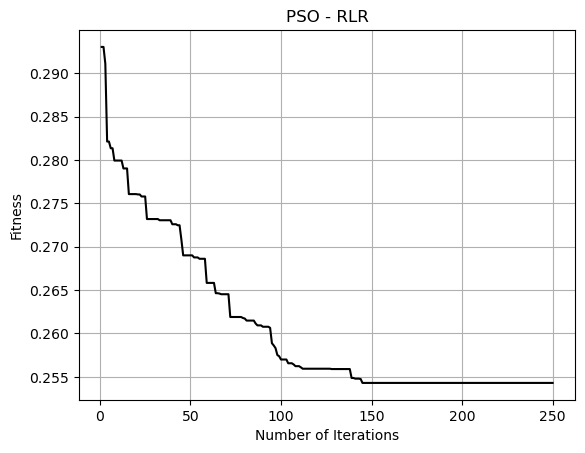

In [24]:
# plot convergence
rlr_sf   = rlr_Results['sf']
rlr_curve   = rlr_Results['c']
rlr_curve   = rlr_curve.reshape(np.size(rlr_curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, rlr_curve, linestyle='-',color='black')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO - RLR')
ax.grid()

plt.show()
fig.savefig("rlr_pso_fitplot.jpg", dpi=300, bbox_inches='tight')

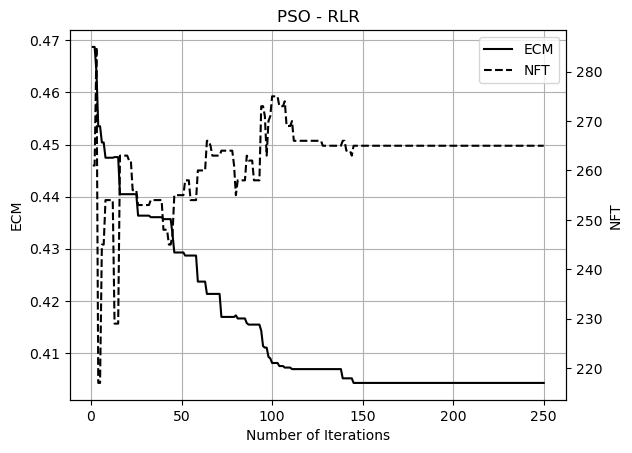

In [25]:
# ECM and number of features
rlr_ecmG = rlr_Results['ecmG']
rlr_ecmG = rlr_ecmG.reshape(np.size(rlr_ecmG,1))
rlr_nft = rlr_Results['NFt']
rlr_nft = rlr_nft.reshape(np.size(rlr_nft,1))
x = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, rlr_ecmG, linestyle='-',color='black', label='ECM')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('ECM')
ax.set_title('PSO - RLR')
ax.grid()

ax2 = ax.twinx()
ax2.plot(x, rlr_nft, linestyle='--',color='black', label='NFT')
ax2.set_ylabel('NFT')
ax2.tick_params(axis='y')

lines = [ax.get_lines()[0], ax2.get_lines()[0]]
ax.legend(lines, [l.get_label() for l in lines], loc='upper right')

plt.show()
fig.savefig("rlr_pso_plot.jpg", dpi=300, bbox_inches='tight')

In [26]:
# Number of selected features
rlr_num_feat = rlr_Results['nf']
print("Feature Size:", rlr_num_feat)

Feature Size: 265


In [27]:
X = complete.drop(columns=['cik','fraud', 'Target', 'res'])
rlr_pso_X = X.columns[rlr_sf]
print(rlr_pso_X)
rlr_pso_data = pd.DataFrame(X, columns = rlr_pso_X)
rlr_pso_data['Target'] = complete['Target']

rlr_pso_data.to_csv('rlr_pso_data.csv',index=False)

Index(['ARtS', 'AFDA', 'AFDAtNS', 'cItS', 'DiRI', 'DfF', '4GSGR', 'GM',
       'HPRiVP', 'ItS',
       ...
       'SIC_7841.0', 'SIC_7948.0', 'SIC_7996.0', 'SIC_8051.0', 'SIC_8071.0',
       'SIC_8082.0', 'SIC_8093.0', 'SIC_8200.0', 'SIC_8731.0', 'SIC_9995.0'],
      dtype='object', length=265)


## PSO - K-Nearest Neighbors

### Running PSO

In [28]:
knn_Results = knn_PSO(xtrain, ytrain, opts)

Global Best updated: 0.349132
Global Best updated: 0.337007
Global Best updated: 0.320028
Global Best updated: 0.318678
Global Best updated: 0.309377
Global Best updated: 0.290016
Current Global Best: 0.290016
Current Global Best ECM: 0.4657
End of iteration: 1
Global Best updated: 0.284624
Global Best updated: 0.274127
Current Global Best: 0.274127
Current Global Best ECM: 0.4394
End of iteration: 2
Current Global Best: 0.274127
Current Global Best ECM: 0.4394
End of iteration: 3
Current Global Best: 0.274127
Current Global Best ECM: 0.4394
End of iteration: 4
Current Global Best: 0.274127
Current Global Best ECM: 0.4394
End of iteration: 5
Current Global Best: 0.274127
Current Global Best ECM: 0.4394
End of iteration: 6
Current Global Best: 0.274127
Current Global Best ECM: 0.4394
End of iteration: 7
Current Global Best: 0.274127
Current Global Best ECM: 0.4394
End of iteration: 8
Global Best updated: 0.272029
Current Global Best: 0.272029
Current Global Best ECM: 0.4357
End of itera

Current Global Best: 0.241487
Current Global Best ECM: 0.3841
End of iteration: 87
Current Global Best: 0.241487
Current Global Best ECM: 0.3841
End of iteration: 88
Current Global Best: 0.241487
Current Global Best ECM: 0.3841
End of iteration: 89
Current Global Best: 0.241487
Current Global Best ECM: 0.3841
End of iteration: 90
Current Global Best: 0.241487
Current Global Best ECM: 0.3841
End of iteration: 91
Current Global Best: 0.241487
Current Global Best ECM: 0.3841
End of iteration: 92
Current Global Best: 0.241487
Current Global Best ECM: 0.3841
End of iteration: 93
Current Global Best: 0.241487
Current Global Best ECM: 0.3841
End of iteration: 94
Current Global Best: 0.241487
Current Global Best ECM: 0.3841
End of iteration: 95
Current Global Best: 0.241487
Current Global Best ECM: 0.3841
End of iteration: 96
Current Global Best: 0.241487
Current Global Best ECM: 0.3841
End of iteration: 97
Current Global Best: 0.241487
Current Global Best ECM: 0.3841
End of iteration: 98
Curr

Current Global Best: 0.241408
Current Global Best ECM: 0.3841
End of iteration: 184
Current Global Best: 0.241408
Current Global Best ECM: 0.3841
End of iteration: 185
Current Global Best: 0.241408
Current Global Best ECM: 0.3841
End of iteration: 186
Current Global Best: 0.241408
Current Global Best ECM: 0.3841
End of iteration: 187
Current Global Best: 0.241408
Current Global Best ECM: 0.3841
End of iteration: 188
Current Global Best: 0.241408
Current Global Best ECM: 0.3841
End of iteration: 189
Current Global Best: 0.241408
Current Global Best ECM: 0.3841
End of iteration: 190
Current Global Best: 0.241408
Current Global Best ECM: 0.3841
End of iteration: 191
Current Global Best: 0.241408
Current Global Best ECM: 0.3841
End of iteration: 192
Current Global Best: 0.241408
Current Global Best ECM: 0.3841
End of iteration: 193
Current Global Best: 0.241408
Current Global Best ECM: 0.3841
End of iteration: 194
Current Global Best: 0.241408
Current Global Best ECM: 0.3841
End of iterati

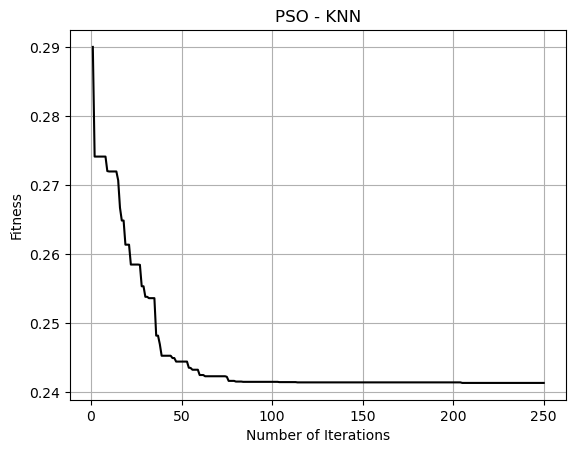

In [29]:
# plot convergence
knn_sf   = knn_Results['sf']
knn_curve   = knn_Results['c']
knn_curve   = knn_curve.reshape(np.size(knn_curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, knn_curve, linestyle='-',color='black')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO - KNN')
ax.grid()

plt.show()
fig.savefig("knn_pso_fitplot.jpg", dpi=300, bbox_inches='tight')

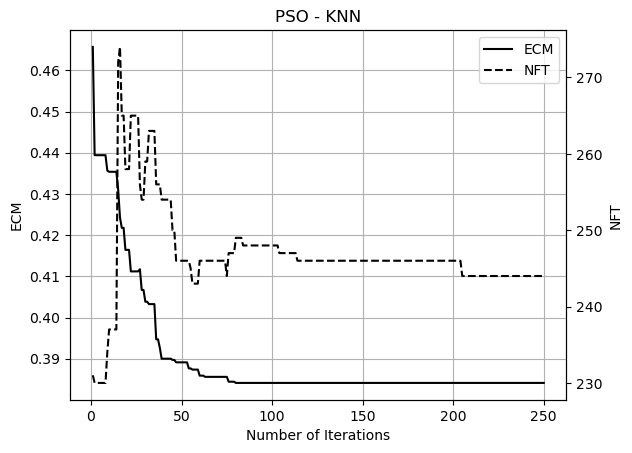

In [30]:
# ECM and number of features
knn_ecmG = knn_Results['ecmG']
knn_ecmG = knn_ecmG.reshape(np.size(knn_ecmG,1))
knn_nft = knn_Results['NFt']
knn_nft = knn_nft.reshape(np.size(knn_nft,1))
x = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, knn_ecmG, linestyle='-',color='black', label='ECM')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('ECM')
ax.set_title('PSO - KNN')
ax.grid()

ax2 = ax.twinx()
ax2.plot(x, knn_nft, linestyle='--',color='black', label='NFT')
ax2.set_ylabel('NFT')
ax2.tick_params(axis='y')

lines = [ax.get_lines()[0], ax2.get_lines()[0]]
ax.legend(lines, [l.get_label() for l in lines], loc='upper right')

plt.show()
fig.savefig("knn_pso_plot.jpg", dpi=300, bbox_inches='tight')

In [31]:
# Number of selected features
knn_num_feat = knn_Results['nf']
print("Feature Size:", knn_num_feat)

Feature Size: 244


In [32]:
X = complete.drop(columns=['cik','fraud', 'Target', 'res'])
knn_pso_X = X.columns[knn_sf]
print(knn_pso_X)
knn_pso_data = pd.DataFrame(X, columns = knn_pso_X)
knn_pso_data['Target'] = complete['Target']

knn_pso_data.to_csv('knn_pso_data.csv',index=False)

Index(['Zscore', 'DfF', 'FAtTT', '4GSGR', 'HPRiVP', 'ItS', 'ROAtTA', 'StTA',
       'TDA', 'IStMV',
       ...
       'SIC_7948.0', 'SIC_7990.0', 'SIC_7996.0', 'SIC_8050.0', 'SIC_8060.0',
       'SIC_8062.0', 'SIC_8082.0', 'SIC_8111.0', 'SIC_8200.0', 'SIC_8711.0'],
      dtype='object', length=244)


## PSO - Light GBM

First, create new x_train and y_train without standardization

In [34]:
# Importing the complete set of features
complete = pd.read_csv('sapso_data.csv')

# Specifying the dependent variable and the potential features
y = pd.Series(data=complete['Target'])
X = complete.drop(columns=['cik','fraud', 'res', 'Target'])

# Split data into train & validation (70 -- 30)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Specifying the numerical columns
num_cols = list(xtrain.select_dtypes(include=['float']).columns)
non_num_cols = list(xtrain.select_dtypes(exclude=['float']).columns)

# Transforming to arrays
ytrain = np.asarray(ytrain)
ytest = np.asarray(ytest)
xtrain = np.asarray(xtrain)
xtest = np.asarray(xtest)

# Adding them to a single fold
fold = {'xt':xtrain, 'yt':ytrain, 'xv':xtest, 'yv':ytest}

# Adding the to the optional parameters
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'c1':c1, 'c2':c2}

# Dimension
dim = np.size(xtrain, 1)

# Making sure each variable has an upper and lower bound
if np.size(lb) == 1:
    ub = ub * np.ones([1, dim], dtype='float')
    lb = lb * np.ones([1, dim], dtype='float')

### Running PSO

In [35]:
lgbm_Results = lgbm_PSO(xtrain, ytrain, opts)

Global Best updated: 0.320354
Global Best updated: 0.307904
Global Best updated: 0.306295
Global Best updated: 0.299925
Global Best updated: 0.295085
Global Best updated: 0.293103
Current Global Best: 0.293103
Current Global Best ECM: 0.4673
End of iteration: 1
Global Best updated: 0.284249
Current Global Best: 0.284249
Current Global Best ECM: 0.4549
End of iteration: 2
Global Best updated: 0.283034
Global Best updated: 0.277237
Global Best updated: 0.275337
Global Best updated: 0.274869
Current Global Best: 0.274869
Current Global Best ECM: 0.4379
End of iteration: 3
Global Best updated: 0.267516
Current Global Best: 0.267516
Current Global Best ECM: 0.4247
End of iteration: 4
Current Global Best: 0.267516
Current Global Best ECM: 0.4247
End of iteration: 5
Global Best updated: 0.267068
Current Global Best: 0.267068
Current Global Best ECM: 0.4234
End of iteration: 6
Global Best updated: 0.261748
Global Best updated: 0.254105
Current Global Best: 0.254105
Current Global Best ECM: 0.4

Global Best updated: 0.24211
Current Global Best: 0.24211
Current Global Best ECM: 0.3823
End of iteration: 89
Current Global Best: 0.24211
Current Global Best ECM: 0.3823
End of iteration: 90
Current Global Best: 0.24211
Current Global Best ECM: 0.3823
End of iteration: 91
Global Best updated: 0.242071
Current Global Best: 0.242071
Current Global Best ECM: 0.3823
End of iteration: 92
Current Global Best: 0.242071
Current Global Best ECM: 0.3823
End of iteration: 93
Current Global Best: 0.242071
Current Global Best ECM: 0.3823
End of iteration: 94
Current Global Best: 0.242071
Current Global Best ECM: 0.3823
End of iteration: 95
Current Global Best: 0.242071
Current Global Best ECM: 0.3823
End of iteration: 96
Current Global Best: 0.242071
Current Global Best ECM: 0.3823
End of iteration: 97
Current Global Best: 0.242071
Current Global Best ECM: 0.3823
End of iteration: 98
Current Global Best: 0.242071
Current Global Best ECM: 0.3823
End of iteration: 99
Current Global Best: 0.242071
C

Current Global Best: 0.240274
Current Global Best ECM: 0.3802
End of iteration: 182
Current Global Best: 0.240274
Current Global Best ECM: 0.3802
End of iteration: 183
Current Global Best: 0.240274
Current Global Best ECM: 0.3802
End of iteration: 184
Current Global Best: 0.240274
Current Global Best ECM: 0.3802
End of iteration: 185
Current Global Best: 0.240274
Current Global Best ECM: 0.3802
End of iteration: 186
Current Global Best: 0.240274
Current Global Best ECM: 0.3802
End of iteration: 187
Current Global Best: 0.240274
Current Global Best ECM: 0.3802
End of iteration: 188
Current Global Best: 0.240274
Current Global Best ECM: 0.3802
End of iteration: 189
Current Global Best: 0.240274
Current Global Best ECM: 0.3802
End of iteration: 190
Current Global Best: 0.240274
Current Global Best ECM: 0.3802
End of iteration: 191
Current Global Best: 0.240274
Current Global Best ECM: 0.3802
End of iteration: 192
Current Global Best: 0.240274
Current Global Best ECM: 0.3802
End of iterati

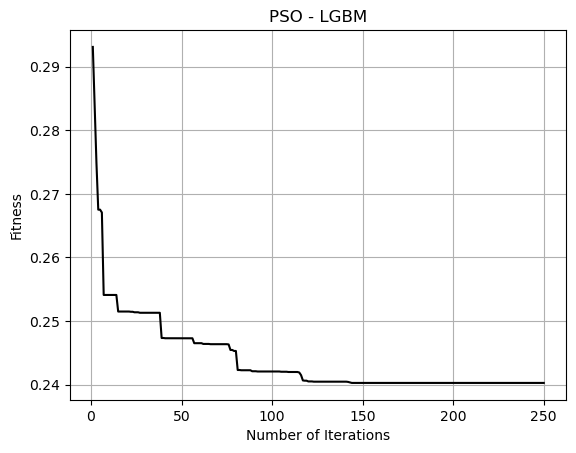

In [36]:
# plot convergence
lgbm_sf   = lgbm_Results['sf']
lgbm_curve   = lgbm_Results['c']
lgbm_curve   = lgbm_curve.reshape(np.size(lgbm_curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, lgbm_curve, linestyle='-',color='black')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO - LGBM')
ax.grid()

plt.show()
fig.savefig("lgbm_pso_fitplot.jpg", dpi=300, bbox_inches='tight')

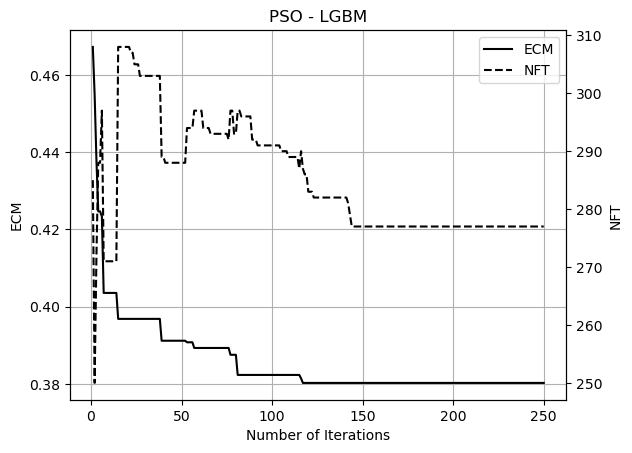

In [37]:
# ECM and number of features
lgbm_ecmG = lgbm_Results['ecmG']
lgbm_ecmG = lgbm_ecmG.reshape(np.size(lgbm_ecmG,1))
lgbm_nft = lgbm_Results['NFt']
lgbm_nft = lgbm_nft.reshape(np.size(lgbm_nft,1))
x = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, lgbm_ecmG, linestyle='-',color='black', label='ECM')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('ECM')
ax.set_title('PSO - LGBM')
ax.grid()

ax2 = ax.twinx()
ax2.plot(x, lgbm_nft, linestyle='--',color='black', label='NFT')
ax2.set_ylabel('NFT')
ax2.tick_params(axis='y')

lines = [ax.get_lines()[0], ax2.get_lines()[0]]
ax.legend(lines, [l.get_label() for l in lines], loc='upper right')

plt.show()
fig.savefig("lgbm_pso_plot.jpg", dpi=300, bbox_inches='tight')

In [38]:
# Number of selected features
lgbm_num_feat = lgbm_Results['nf']
print("Feature Size:", lgbm_num_feat)

Feature Size: 277


In [39]:
X = complete.drop(columns=['cik','fraud', 'Target', 'res'])
lgbm_pso_X = X.columns[lgbm_sf]
print(lgbm_pso_X)
lgbm_pso_data = pd.DataFrame(X, columns = lgbm_pso_X)
lgbm_pso_data['Target'] = complete['Target']

lgbm_pso_data.to_csv('lgbm_pso_data.csv',index=False)

Index(['ARtTA', 'AFDA', 'AFDAtAR', 'AFDAtNS', 'Zscore', 'Big4', 'DfF', 'DCS',
       'FAtTT', '4GSGR',
       ...
       'SIC_7381.0', 'SIC_7510.0', 'SIC_7841.0', 'SIC_8011.0', 'SIC_8060.0',
       'SIC_8062.0', 'SIC_8111.0', 'SIC_8200.0', 'SIC_8711.0', 'SIC_8721.0'],
      dtype='object', length=277)
